In [1]:
# 숙제 2
import requests
import tarfile
import os
# 데이터 다운로드 URL
urls = [
    "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
    "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
]
# 파일 다운로드 함수
def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    local_filename = os.path.join(dest_folder, url.split('/')[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename
# 각 URL에 대해 파일 다운로드
for url in urls:
    download_file(url, 'data')
# 파일 압축 해제
def extract_tar_gz(file_path, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=dest_folder)
# 각 파일에 대해 압축 해제
for url in urls:
    file_path = os.path.join('data', url.split('/')[-1])
    extract_tar_gz(file_path, 'data')

In [2]:
import os

# 디렉토리 구조 확인
for root, dirs, files in os.walk('data'):
    level = root.replace('data', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

data/
    annotations.tar.gz
    images.tar.gz
    images/
        Egyptian_Mau_167.jpg
        pug_52.jpg
        basset_hound_112.jpg
        Siamese_193.jpg
        shiba_inu_122.jpg
        Siamese_53.jpg
        Birman_167.jpg
        leonberger_6.jpg
        Siamese_47.jpg
        shiba_inu_136.jpg
        saint_bernard_139.jpg
        Birman_173.jpg
        Abyssinian_225.jpg
        basset_hound_106.jpg
        miniature_pinscher_200.jpg
        Siamese_187.jpg
        wheaten_terrier_49.jpg
        Egyptian_Mau_173.jpg
        pug_46.jpg
        shiba_inu_43.jpg
        wheaten_terrier_61.jpg
        saint_bernard_111.jpg
        scottish_terrier_132.jpg
        scottish_terrier_126.jpg
        saint_bernard_105.jpg
        saint_bernard_2.jpg
        pomeranian_189.jpg
        Abyssinian_219.jpg
        shiba_inu_57.jpg
        wheaten_terrier_75.jpg
        german_shorthaired_131.jpg
        english_setter_170.jpg
        pug_91.jpg
        newfoundland_137.jpg
        pomer

In [38]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(42)

In [3]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [5]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

In [7]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6366 - accuracy: 0.6812 - val_loss: 0.6079 - val_accuracy: 0.6750
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.7000 - val_loss: 0.5943 - val_accuracy: 0.7000
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.6043 - accuracy: 0.7125 - val_loss: 0.5817 - val_accuracy: 0.7250
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.5903 - accuracy: 0.7250 - val_loss: 0.5690 - val_accuracy: 0.7250
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.5769 - accuracy: 0.7250 - val_loss: 0.5571 - val_accuracy: 0.7500
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.5642 - accuracy: 0.7500 - val_loss: 0.5458 - val_accuracy: 0.7750
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.5521 - accuracy: 0.7500 - val_loss: 0.5346 - val_accuracy: 0.8000
Epoch 8/50
5/5 [=================

In [8]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"테스트 데이터 정확도: {accuracy*100:.2f}%")

4/4 [==============================] - 0s 970us/step - loss: 0.6314 - accuracy: 0.7475
테스트 데이터 정확도: 74.75%


In [9]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

4/4 [==============================] - 0s 938us/step


## 강사님 코드

In [39]:
import warnings
warnings.filterwarnings(action='ignore')

In [40]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


<Axes: xlabel='DEATH_EVENT', ylabel='count'>

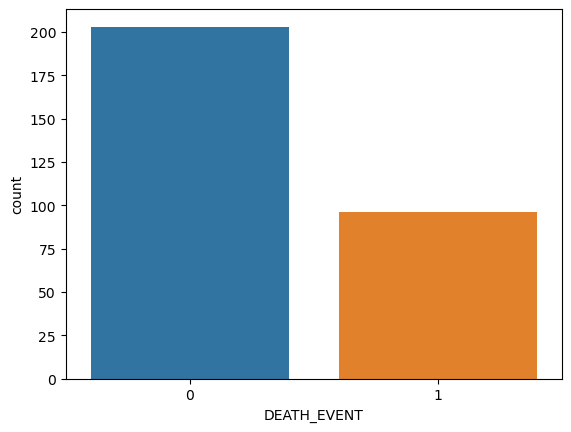

In [42]:
sns.countplot(x = data['DEATH_EVENT'])

<Axes: >

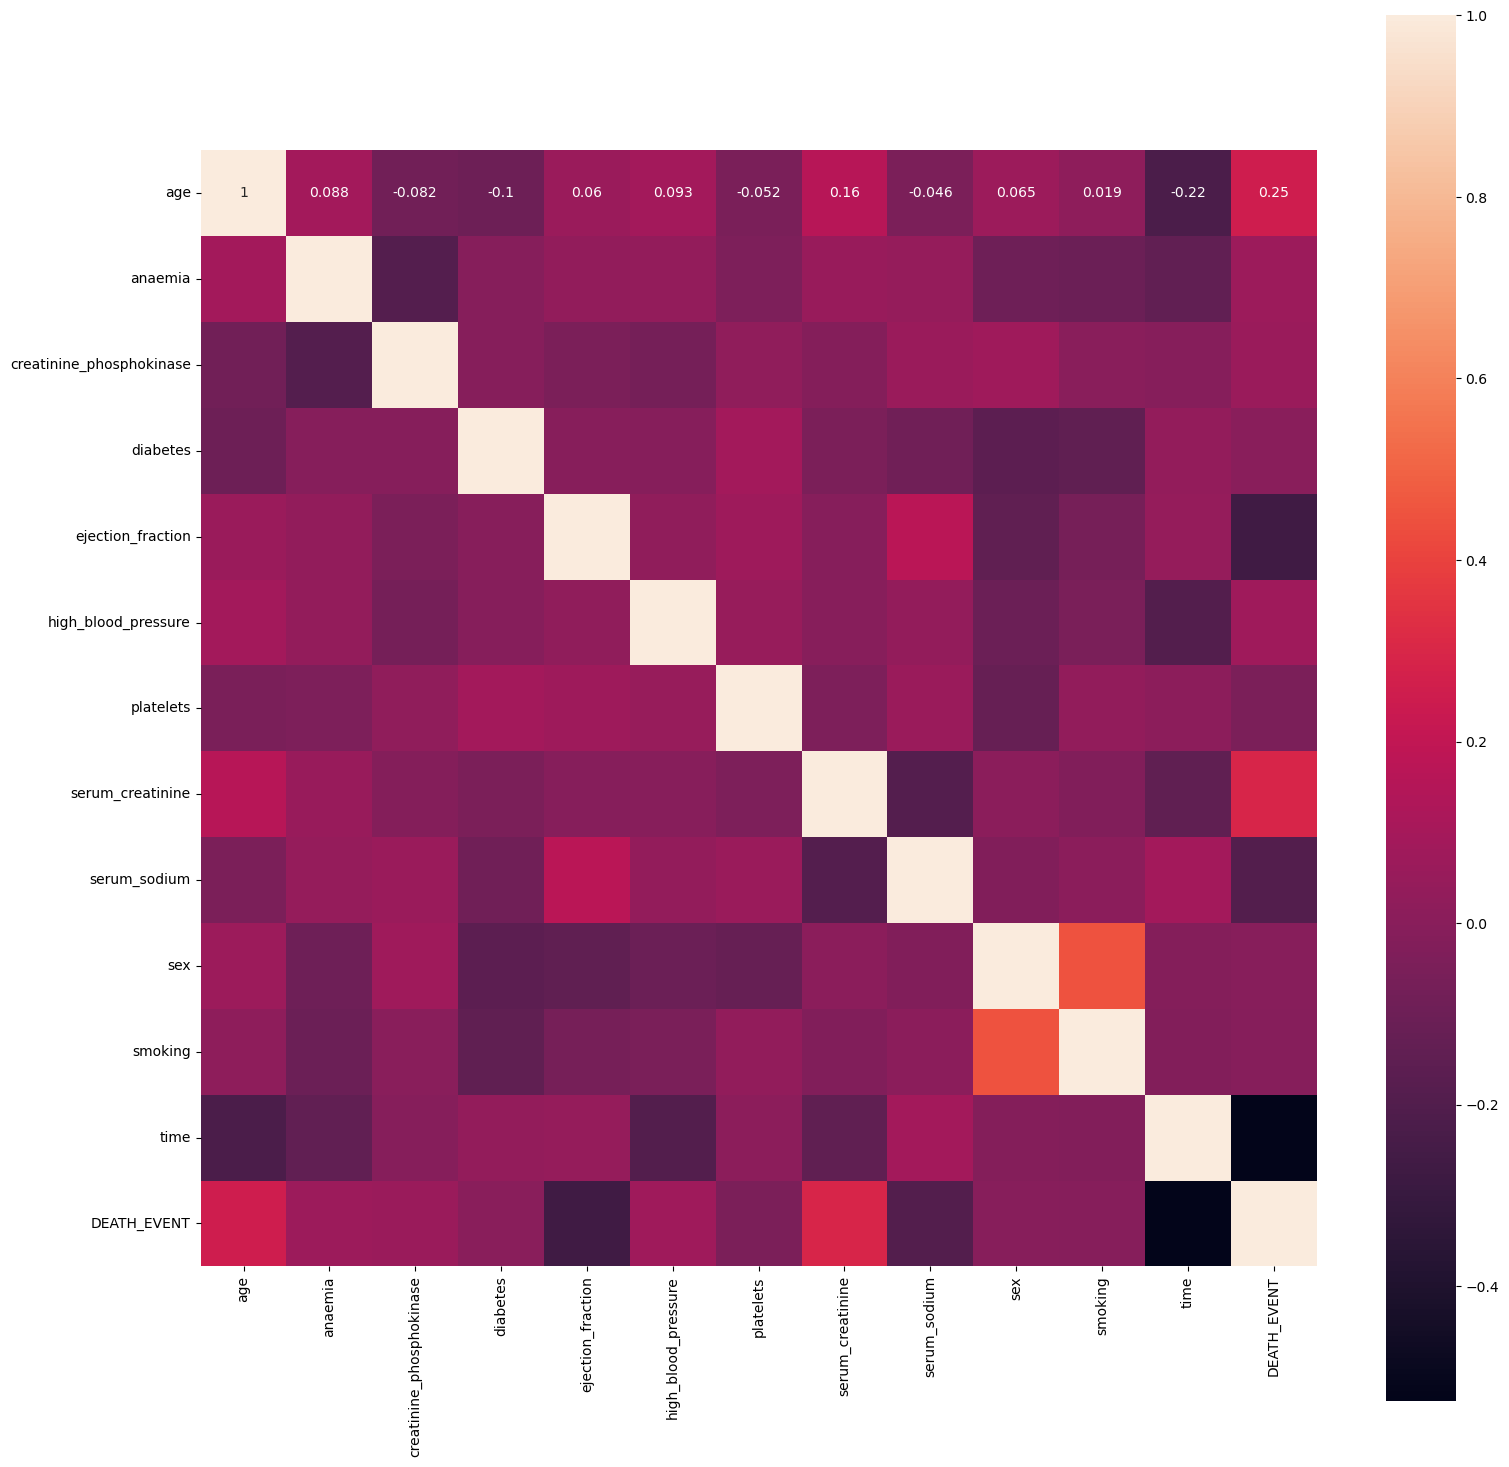

In [43]:
corrmat = data.corr()
plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat, annot=True, square=True)

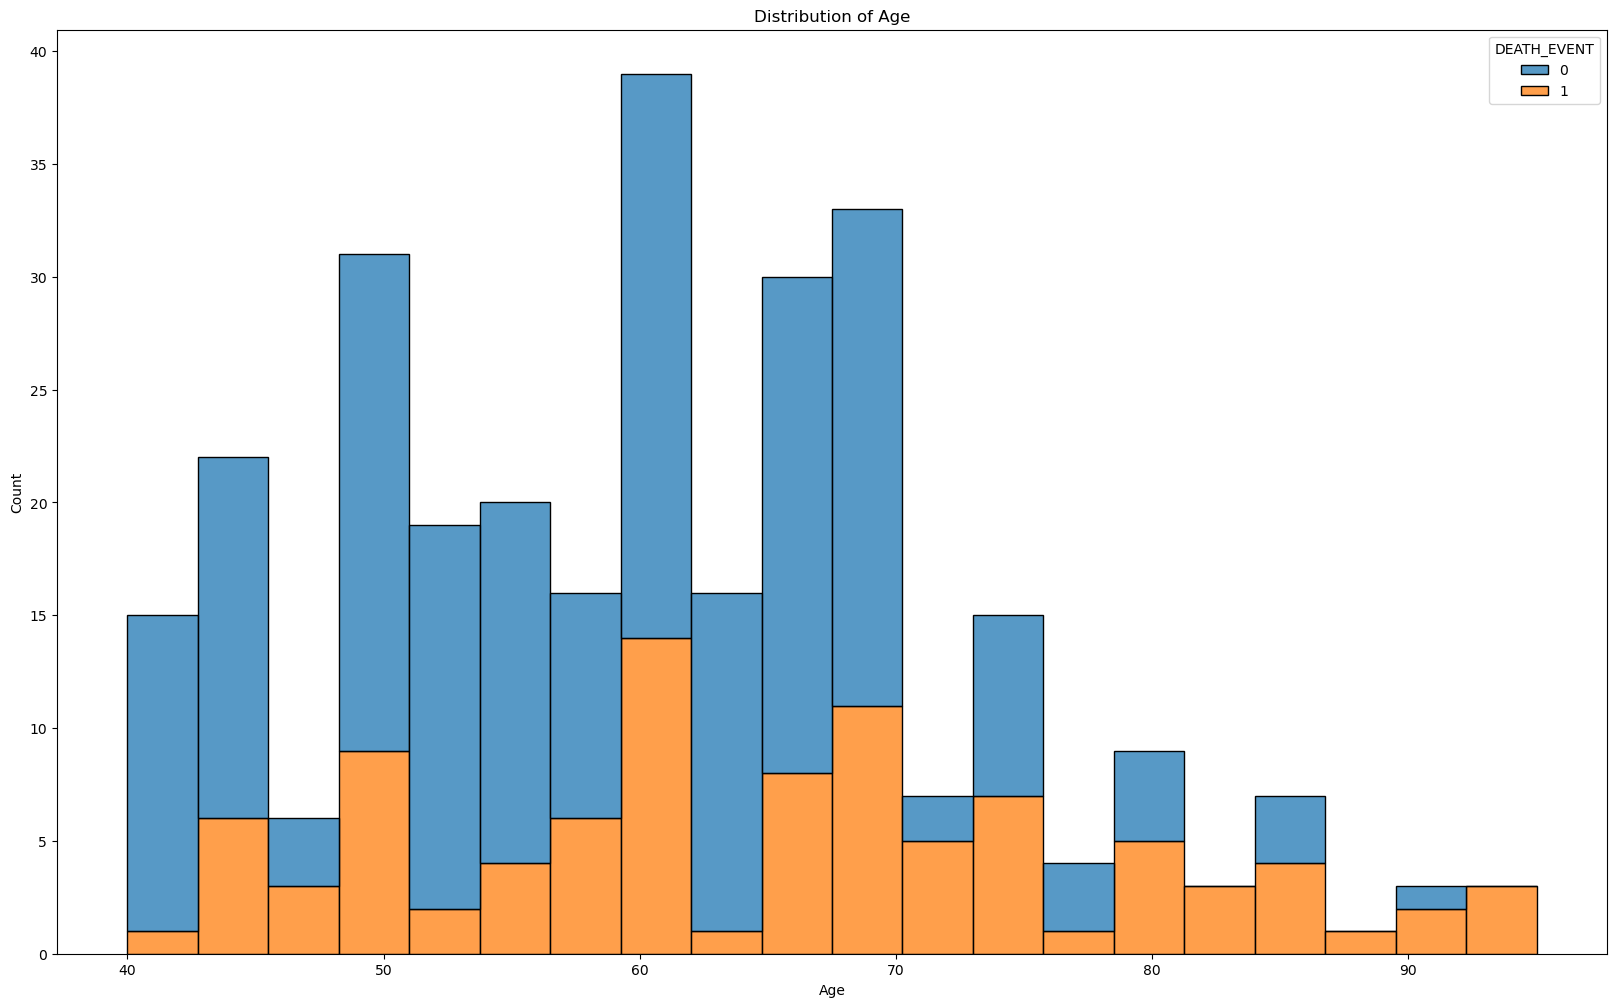

In [44]:
plt.figure(figsize=(20, 12))
age_dist = sns.histplot(data=data, x='age', hue='DEATH_EVENT', multiple='stack', bins=20)
age_dist.set_title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

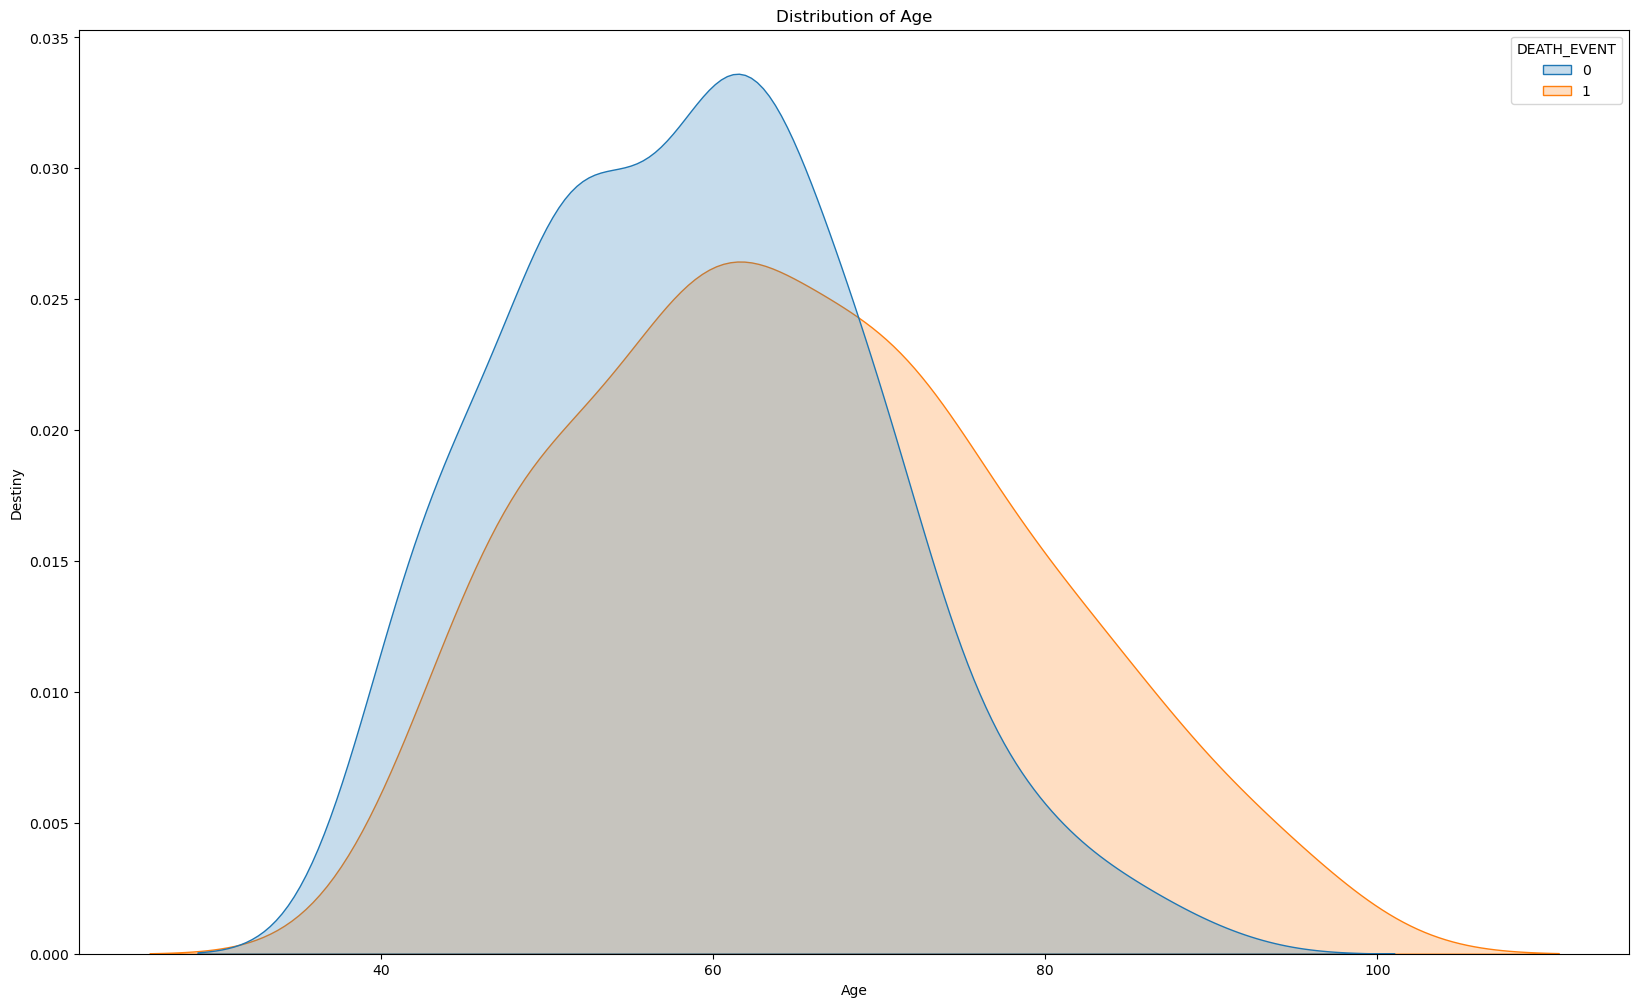

In [45]:
plt.figure(figsize=(20, 12))
sns.kdeplot(data=data, x='age', hue='DEATH_EVENT', fill=True, common_norm=False)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Destiny')
plt.show()

In [46]:
data.head(1)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1


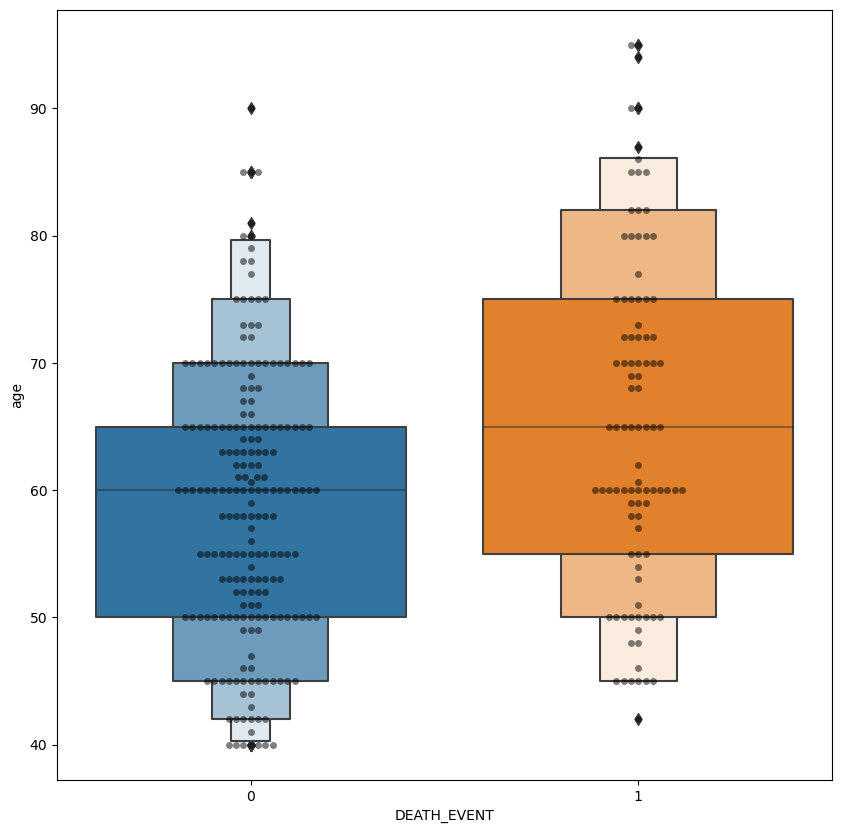

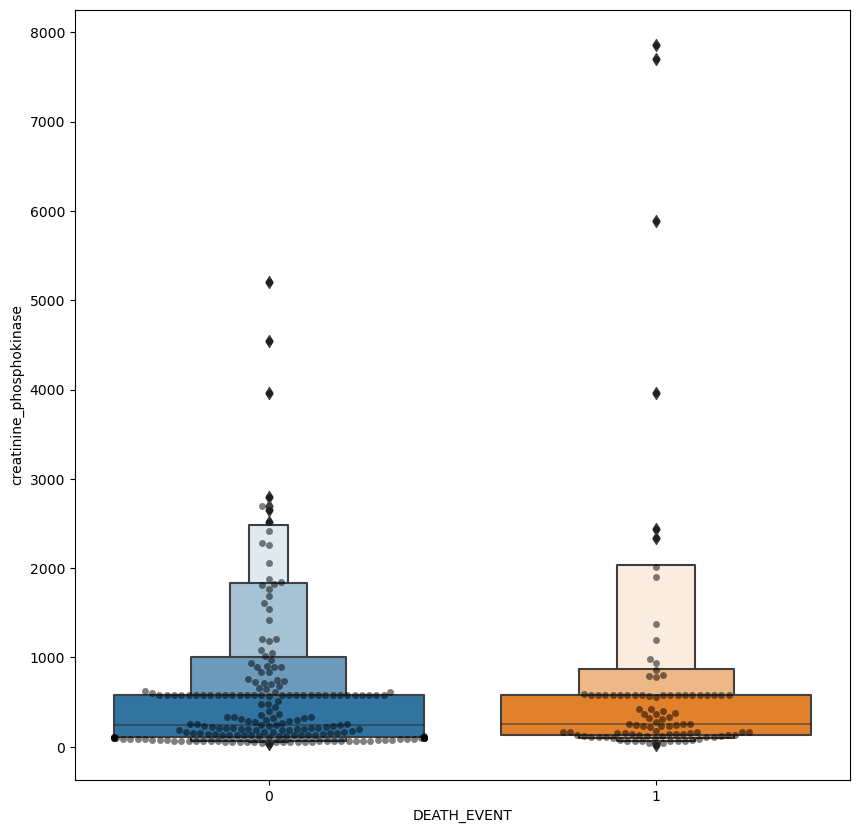

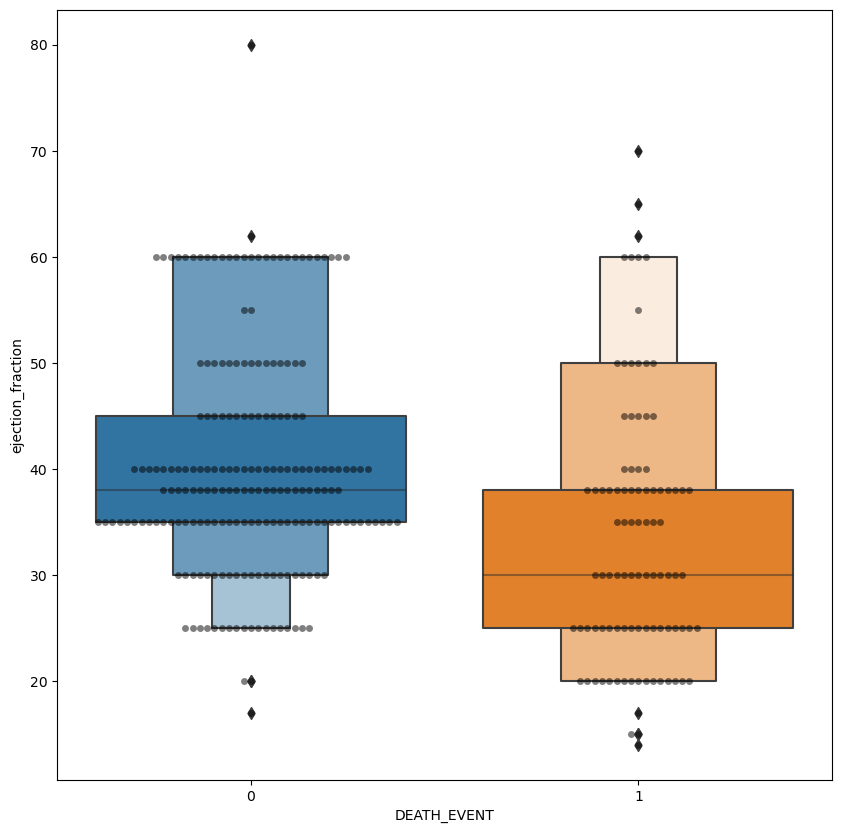

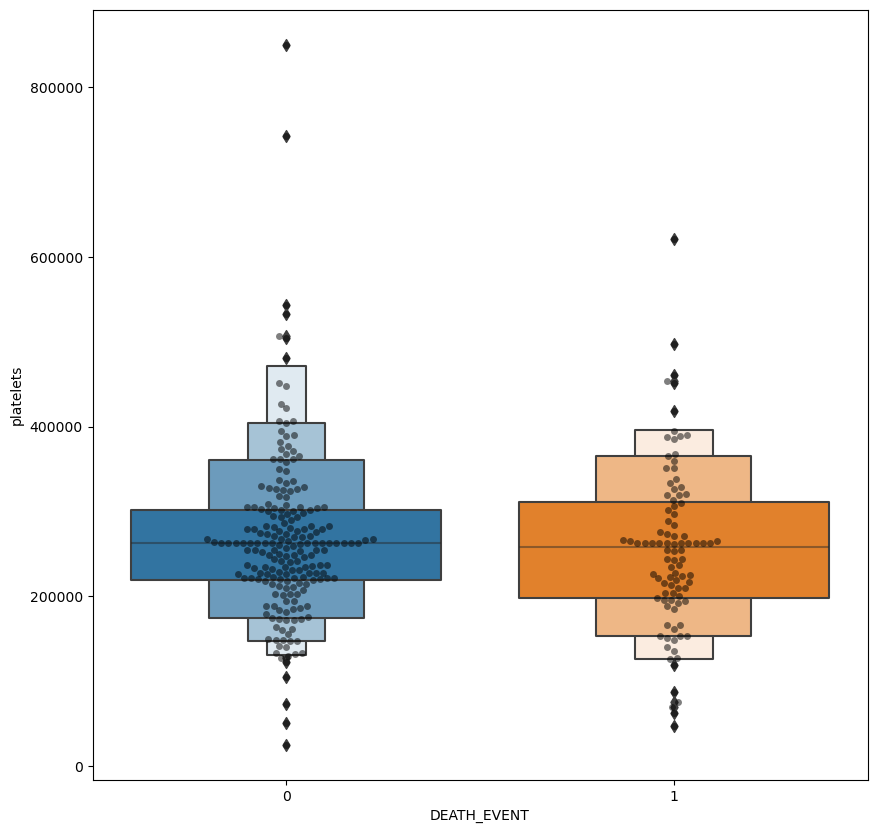

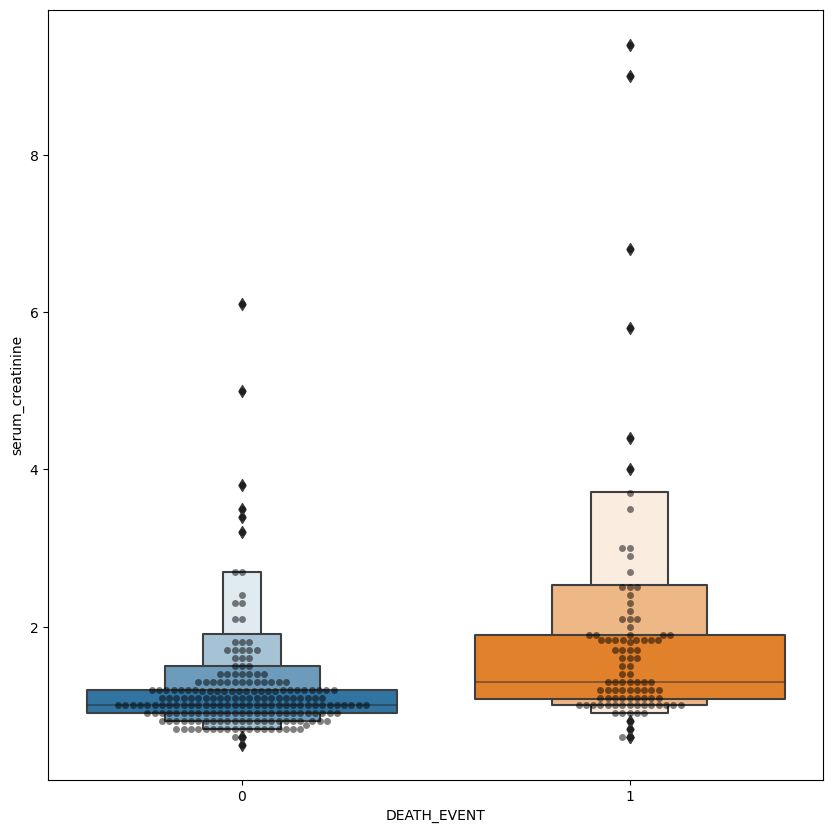

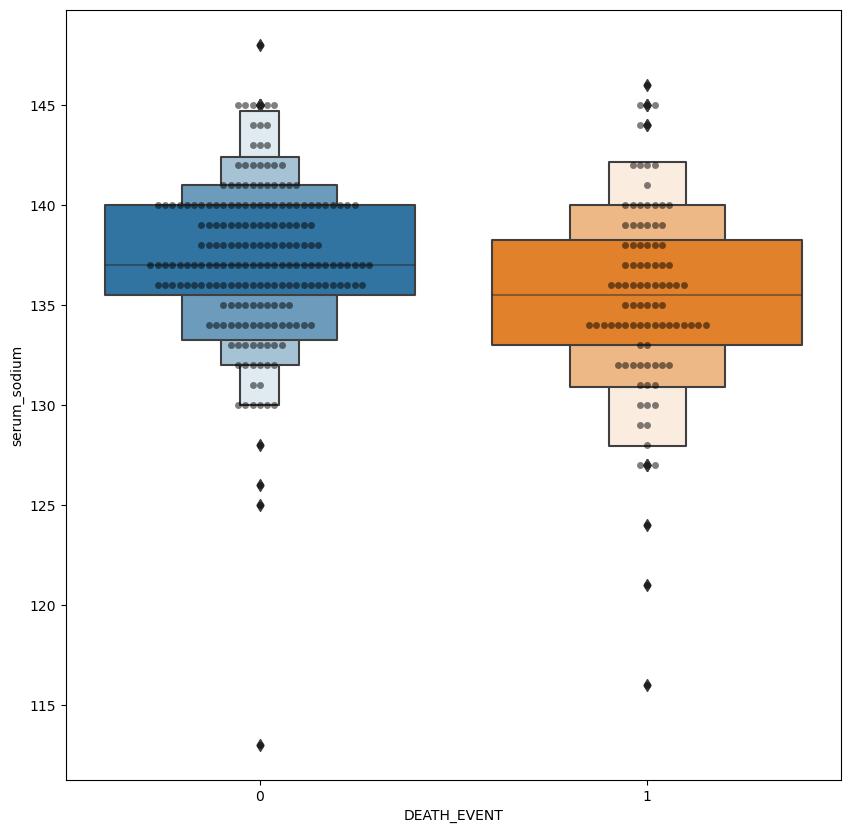

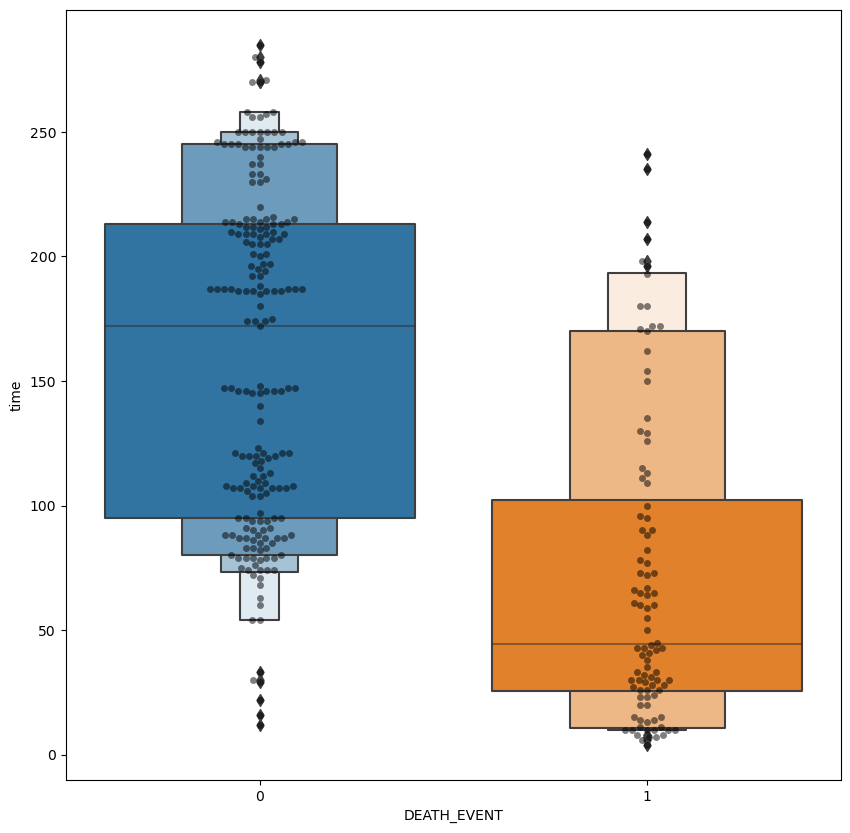

In [47]:
feature=['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
for i in feature:
    plt.figure(figsize=(10, 10))
    sns.swarmplot(x=data['DEATH_EVENT'], y=data[i], color='black', alpha=0.5)
    sns.boxenplot(x=data['DEATH_EVENT'], y=data[i])
    plt.show()

<Axes: xlabel='time', ylabel='age'>

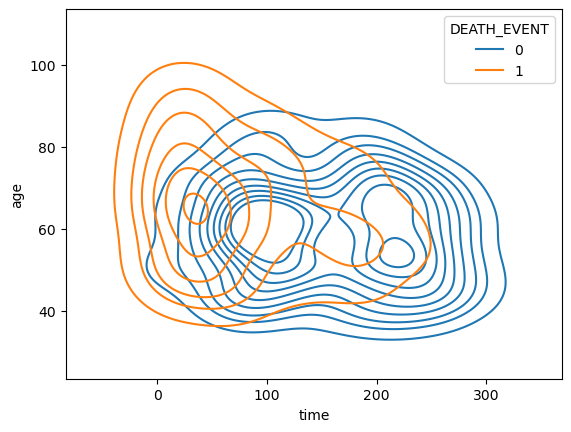

In [48]:
# 나이와 시간관계
sns.kdeplot(x=data['time'], y=data['age'], hue=data['DEATH_EVENT'])

In [49]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [50]:
X = data.drop(['DEATH_EVENT'], axis=1)
y = data['DEATH_EVENT']

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_df = pd.DataFrame(X_scaled, columns=X.columns)
X_df.head().T

,0,1,2,3,4
age,1.192945,-4.912793e-01,0.350833,-0.912335,0.350833
anaemia,-0.871105,-8.711048e-01,-0.871105,1.147968,1.147968
creatinine_phosphokinase,0.000166,7.514640e+00,-0.449939,-0.486071,-0.435486
diabetes,-0.847579,-8.475794e-01,-0.847579,-0.847579,1.179830
ejection_fraction,-1.530560,-7.076750e-03,-1.530560,-1.530560,-1.530560
high_blood_pressure,1.359272,-7.356882e-01,-0.735688,-0.735688,-0.735688
platelets,0.016816,7.535660e-09,-1.038073,-0.546474,0.651799
serum_creatinine,0.490057,-2.845524e-01,-0.090900,0.490057,1.264666
serum_sodium,-1.504036,-1.419762e-01,-1.731046,0.085034,-4.682176
sex,0.735688,7.356882e-01,0.735688,0.735688,-1.359272


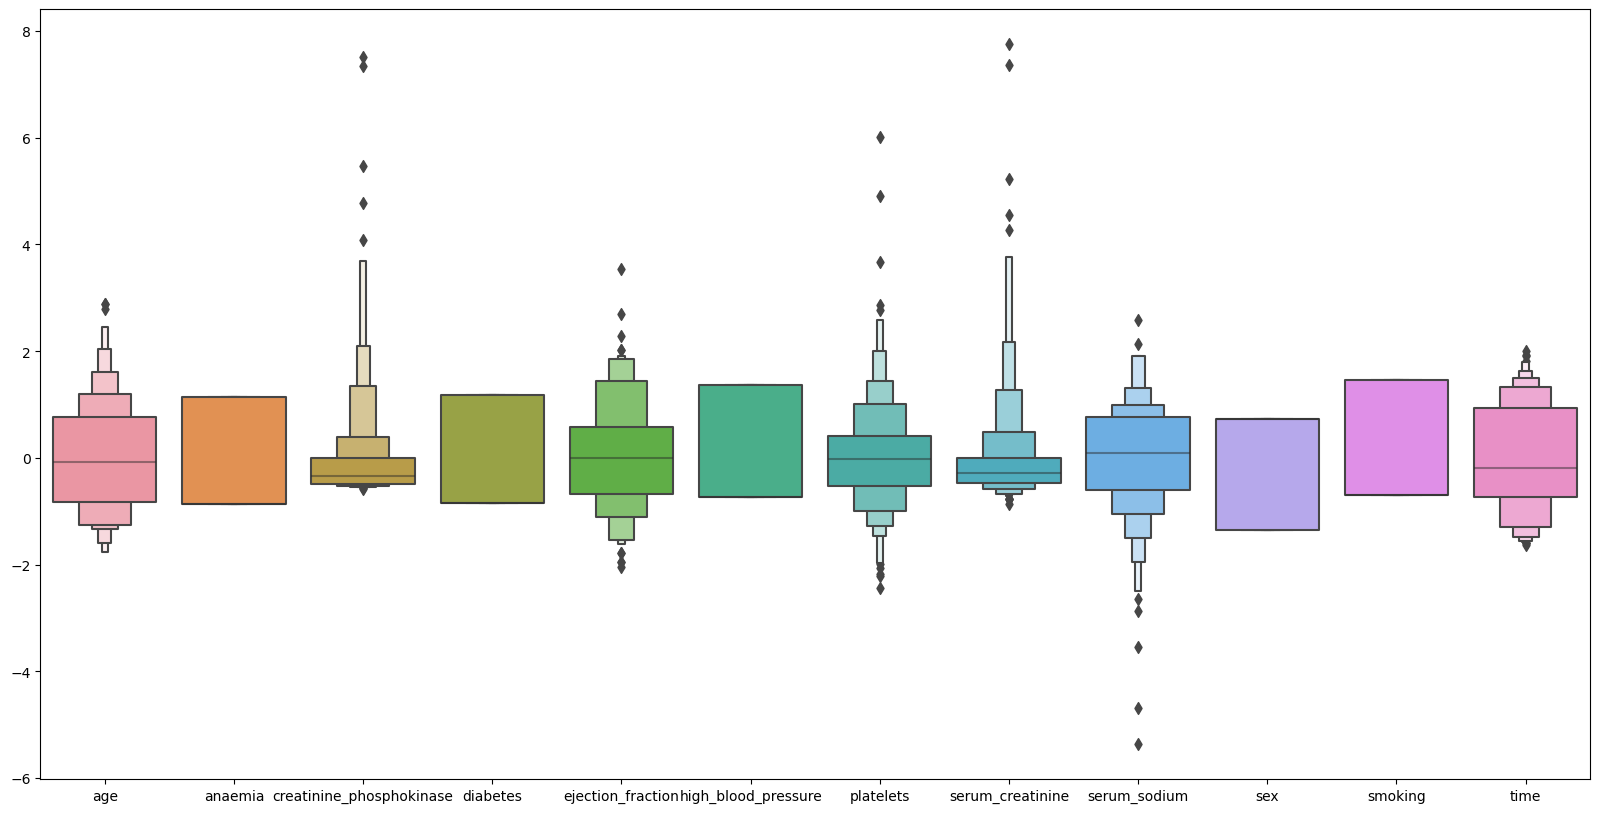

In [52]:
plt.figure(figsize=(20,10))
sns.boxenplot(data=X_df)
plt.show()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.33, random_state=42)

## ANN 모델 만들기
- EarlyStopping : min_delta = 0.001, patience=20
- Sequential 모델
    - Dense(뉴런 16, uniform, relu, dim=12)
    - Dense(뉴런 8, uniform, relu)
    - 0.25만큼 드롭아웃(과적합 방지)
    - Dense(뉴런 4, uniform, relu)
    - 0.5 드롭아웃
    - Dense(뉴런 1, uniform, sigmoid)
 
- 컴파일 : adam(검증함수(최적화 알고리즘)), binary_crossentropy(손실 함수), 정확도(지표)

- 학습 : batch_size=32, epochs = 500, 0.2는 검증 데이터로 사용 

In [63]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True # 종료 시점에 최고 가중치를 복원하겠다.(모델 성능 향상을 위해)
)

model = Sequential()
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_dim=12))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.25)) # 과적합 방지
model.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5)) # 과적합 방지
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# opt = Adam(learning_rate = 0.0001)으로 설정 후 진행해도 된다.
# 설정을 안하고 그냥 adam을 적어주면 디폴트값 0.0001이 들어가게 된다.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/500
5/5 [==============================] - 0s 22ms/step - loss: 0.6927 - accuracy: 0.6187 - val_loss: 0.6917 - val_accuracy: 0.8000
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.7125 - val_loss: 0.6902 - val_accuracy: 0.8000
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.7125 - val_loss: 0.6887 - val_accuracy: 0.8000
Epoch 4/500
5/5 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.7125 - val_loss: 0.6872 - val_accuracy: 0.8000
Epoch 5/500
5/5 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.7125 - val_loss: 0.6856 - val_accuracy: 0.8000
Epoch 6/500
5/5 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.7125 - val_loss: 0.6840 - val_accuracy: 0.8000
Epoch 7/500
5/5 [==============================] - 0s 5ms/step - loss: 0.6861 - accuracy: 0.7125 - val_loss: 0.6824 - val_accuracy: 0.8000
Epoch 8/500
5/5 [=========

In [59]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"테스트 데이터 정확도: {accuracy*100:.2f}%")

4/4 [==============================] - 0s 3ms/step - loss: 0.5434 - accuracy: 0.7879
테스트 데이터 정확도: 78.79%


In [65]:
# 검증 데이터의 정확도 살펴보기
np.mean(history.history['val_accuracy'])

0.8040760943423146

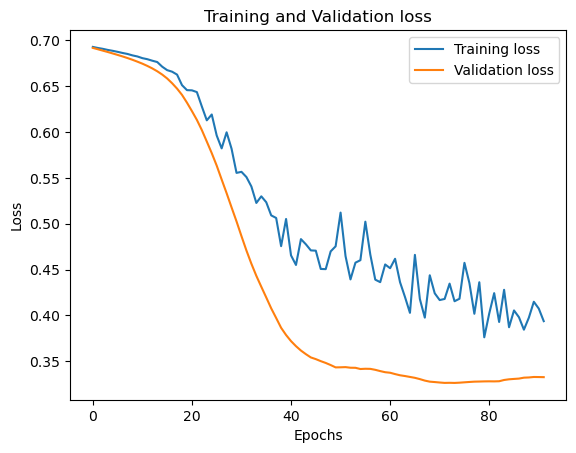

In [67]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

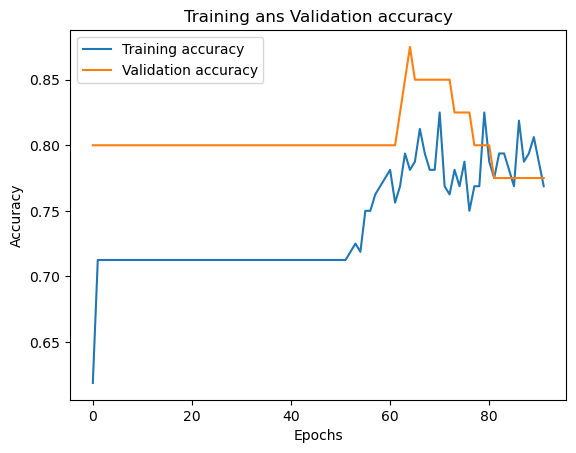

In [68]:
# 정확도 그래프
plt.plot(history_df.loc[:, ['accuracy']], label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], label='Validation accuracy')

plt.title('Training ans Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [69]:
# 학습 진행
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

4/4 [==============================] - 0s 805us/step


In [71]:
y_pred # True, False로 바꾸어준 것(예측 결과를)

array([[False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [

<Axes: >

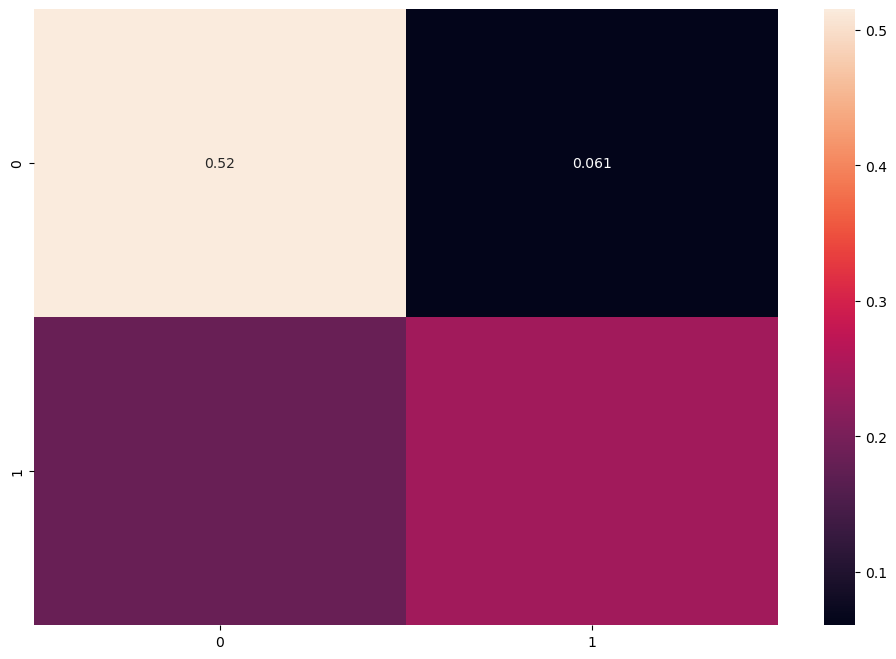

In [72]:
plt.subplots(figsize=(12, 8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81        57
           1       0.80      0.57      0.67        42

    accuracy                           0.76        99
   macro avg       0.77      0.73      0.74        99
weighted avg       0.76      0.76      0.75        99

